In [12]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf
from kalman_filter import Kalman1D
import pandas_datareader as pdr
import time

# 1 读取数据

In [13]:
stock_name = 'AAPL'
stock_data = pd.read_csv('StockData/{}.csv'.format(stock_name))

In [14]:
stock_data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-03,46.115002,46.235001,45.302502,46.205002,44.231552,163210000
1,2018-12-04,45.237499,45.597500,44.067501,44.172501,42.285866,165377200
2,2018-12-06,42.939999,43.695000,42.605000,43.680000,41.814392,172393600


In [15]:
stock_data.info()    #观察表的信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1016 non-null   object 
 1   Open       1016 non-null   float64
 2   High       1016 non-null   float64
 3   Low        1016 non-null   float64
 4   Close      1016 non-null   float64
 5   Adj Close  1016 non-null   float64
 6   Volume     1016 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.7+ KB


# 2 数据处理与分析
##（1）卡尔曼滤波

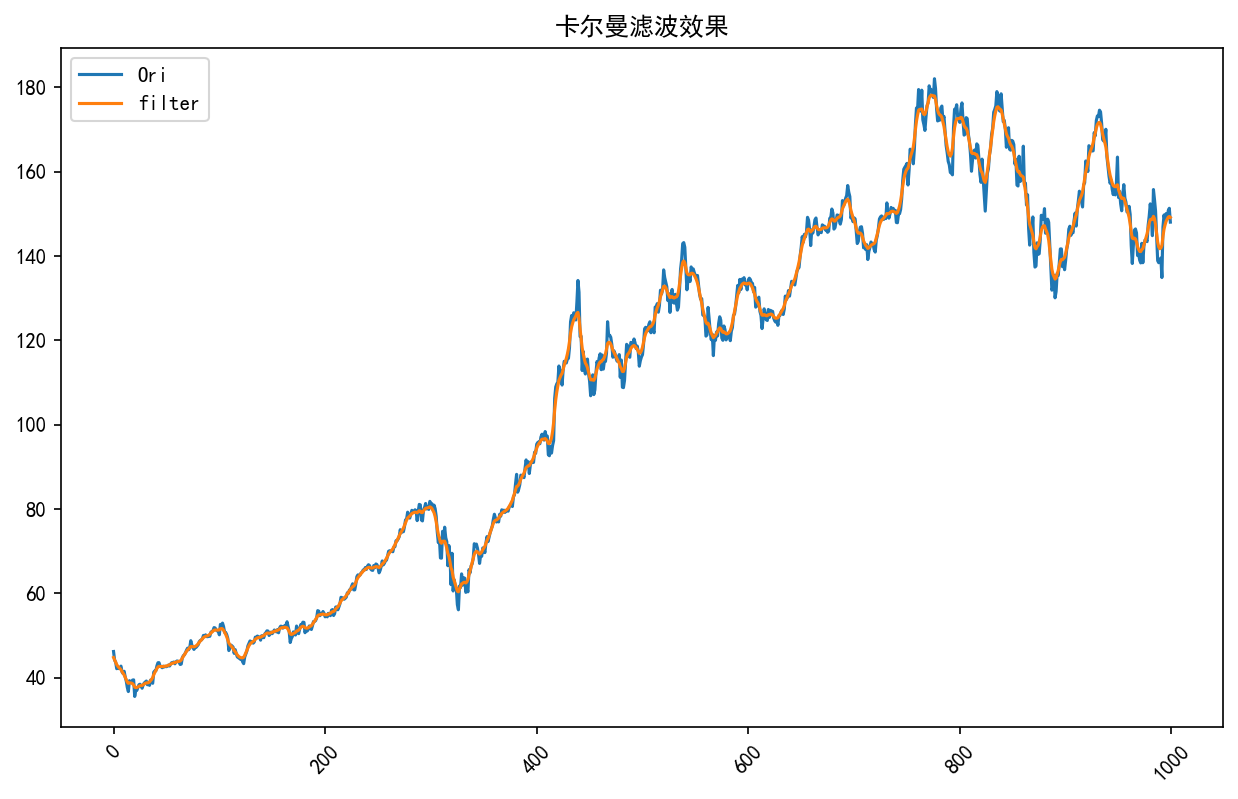

In [28]:
end=1000
ori_data=stock_data['Close'][:end]
filter_data=Kalman1D(ori_data,0.5)  #卡尔曼滤波

plt.figure(figsize=(10,6),dpi=150)
plt.plot(list(stock_data.index)[:end],ori_data[:end],label="Ori")
plt.plot(list(stock_data.index)[:end],filter_data[:end],label="filter")
plt.xticks(rotation=45)
plt.legend()
plt.title("卡尔曼滤波效果")
plt.show()

## （2）ACF检验

ADF: -1.3340336327291293
pvalue: 0.6134616793819129


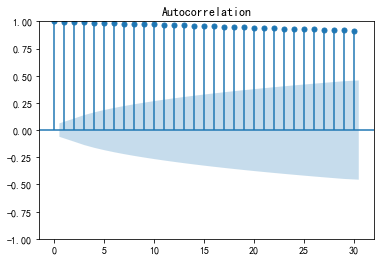

In [29]:

plot_acf(ori_data)   #蓝色画出的是95%置信度区域，落在区域外说明在x轴的时间间隔下数据相关，横坐标表示lag，时间间隔

adf,p_value,usedlag,nobs,critical_value,icbest=adfuller(ori_data)
print("ADF:",adf)
print("pvalue:",p_value)    #由pvalue知数据不平稳
plt.show()

## (3) 差分

1 阶差分
1.4056703572445025e-15


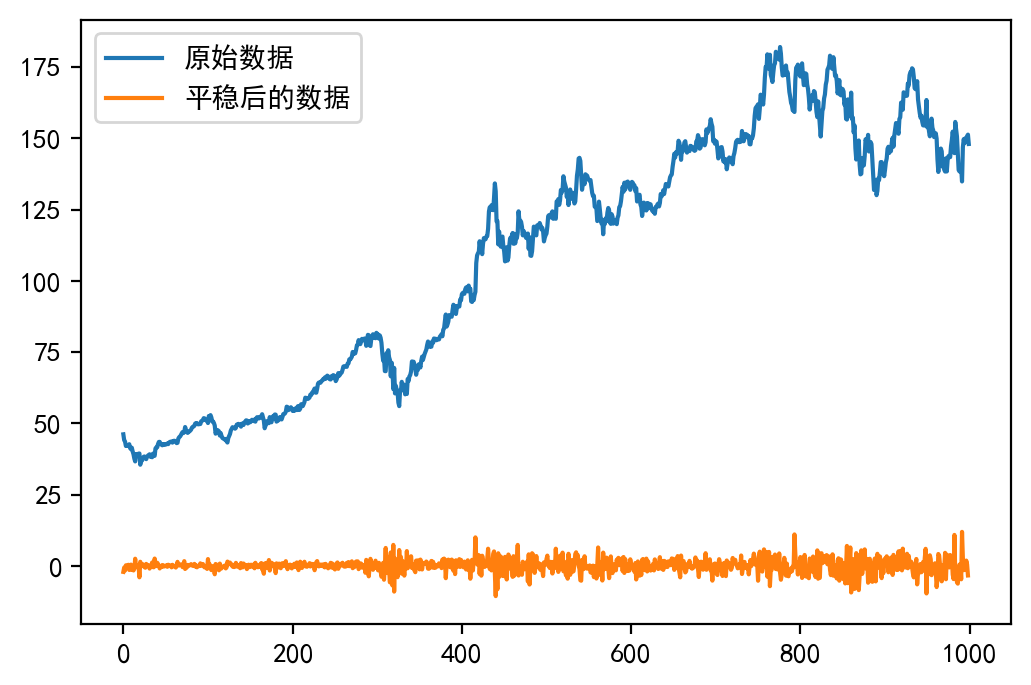

In [46]:
def toStationary(data,threshold):
    p=0
    while(True):
        p+=1
        data=np.diff(data)   #差分
        result=adfuller(data)
        if result[1]<threshold:   #如果p_value小于阈值
            break
        
    print(p,"阶差分")
    return data,result[1]

data=ori_data.astype('float')
sta_data,p_val=toStationary(data,0.05)
print(p_val)
plt.figure(dpi=200)
plt.plot(data,label="原始数据")
plt.plot(sta_data,label="平稳后的数据")
plt.legend()
plt.show()

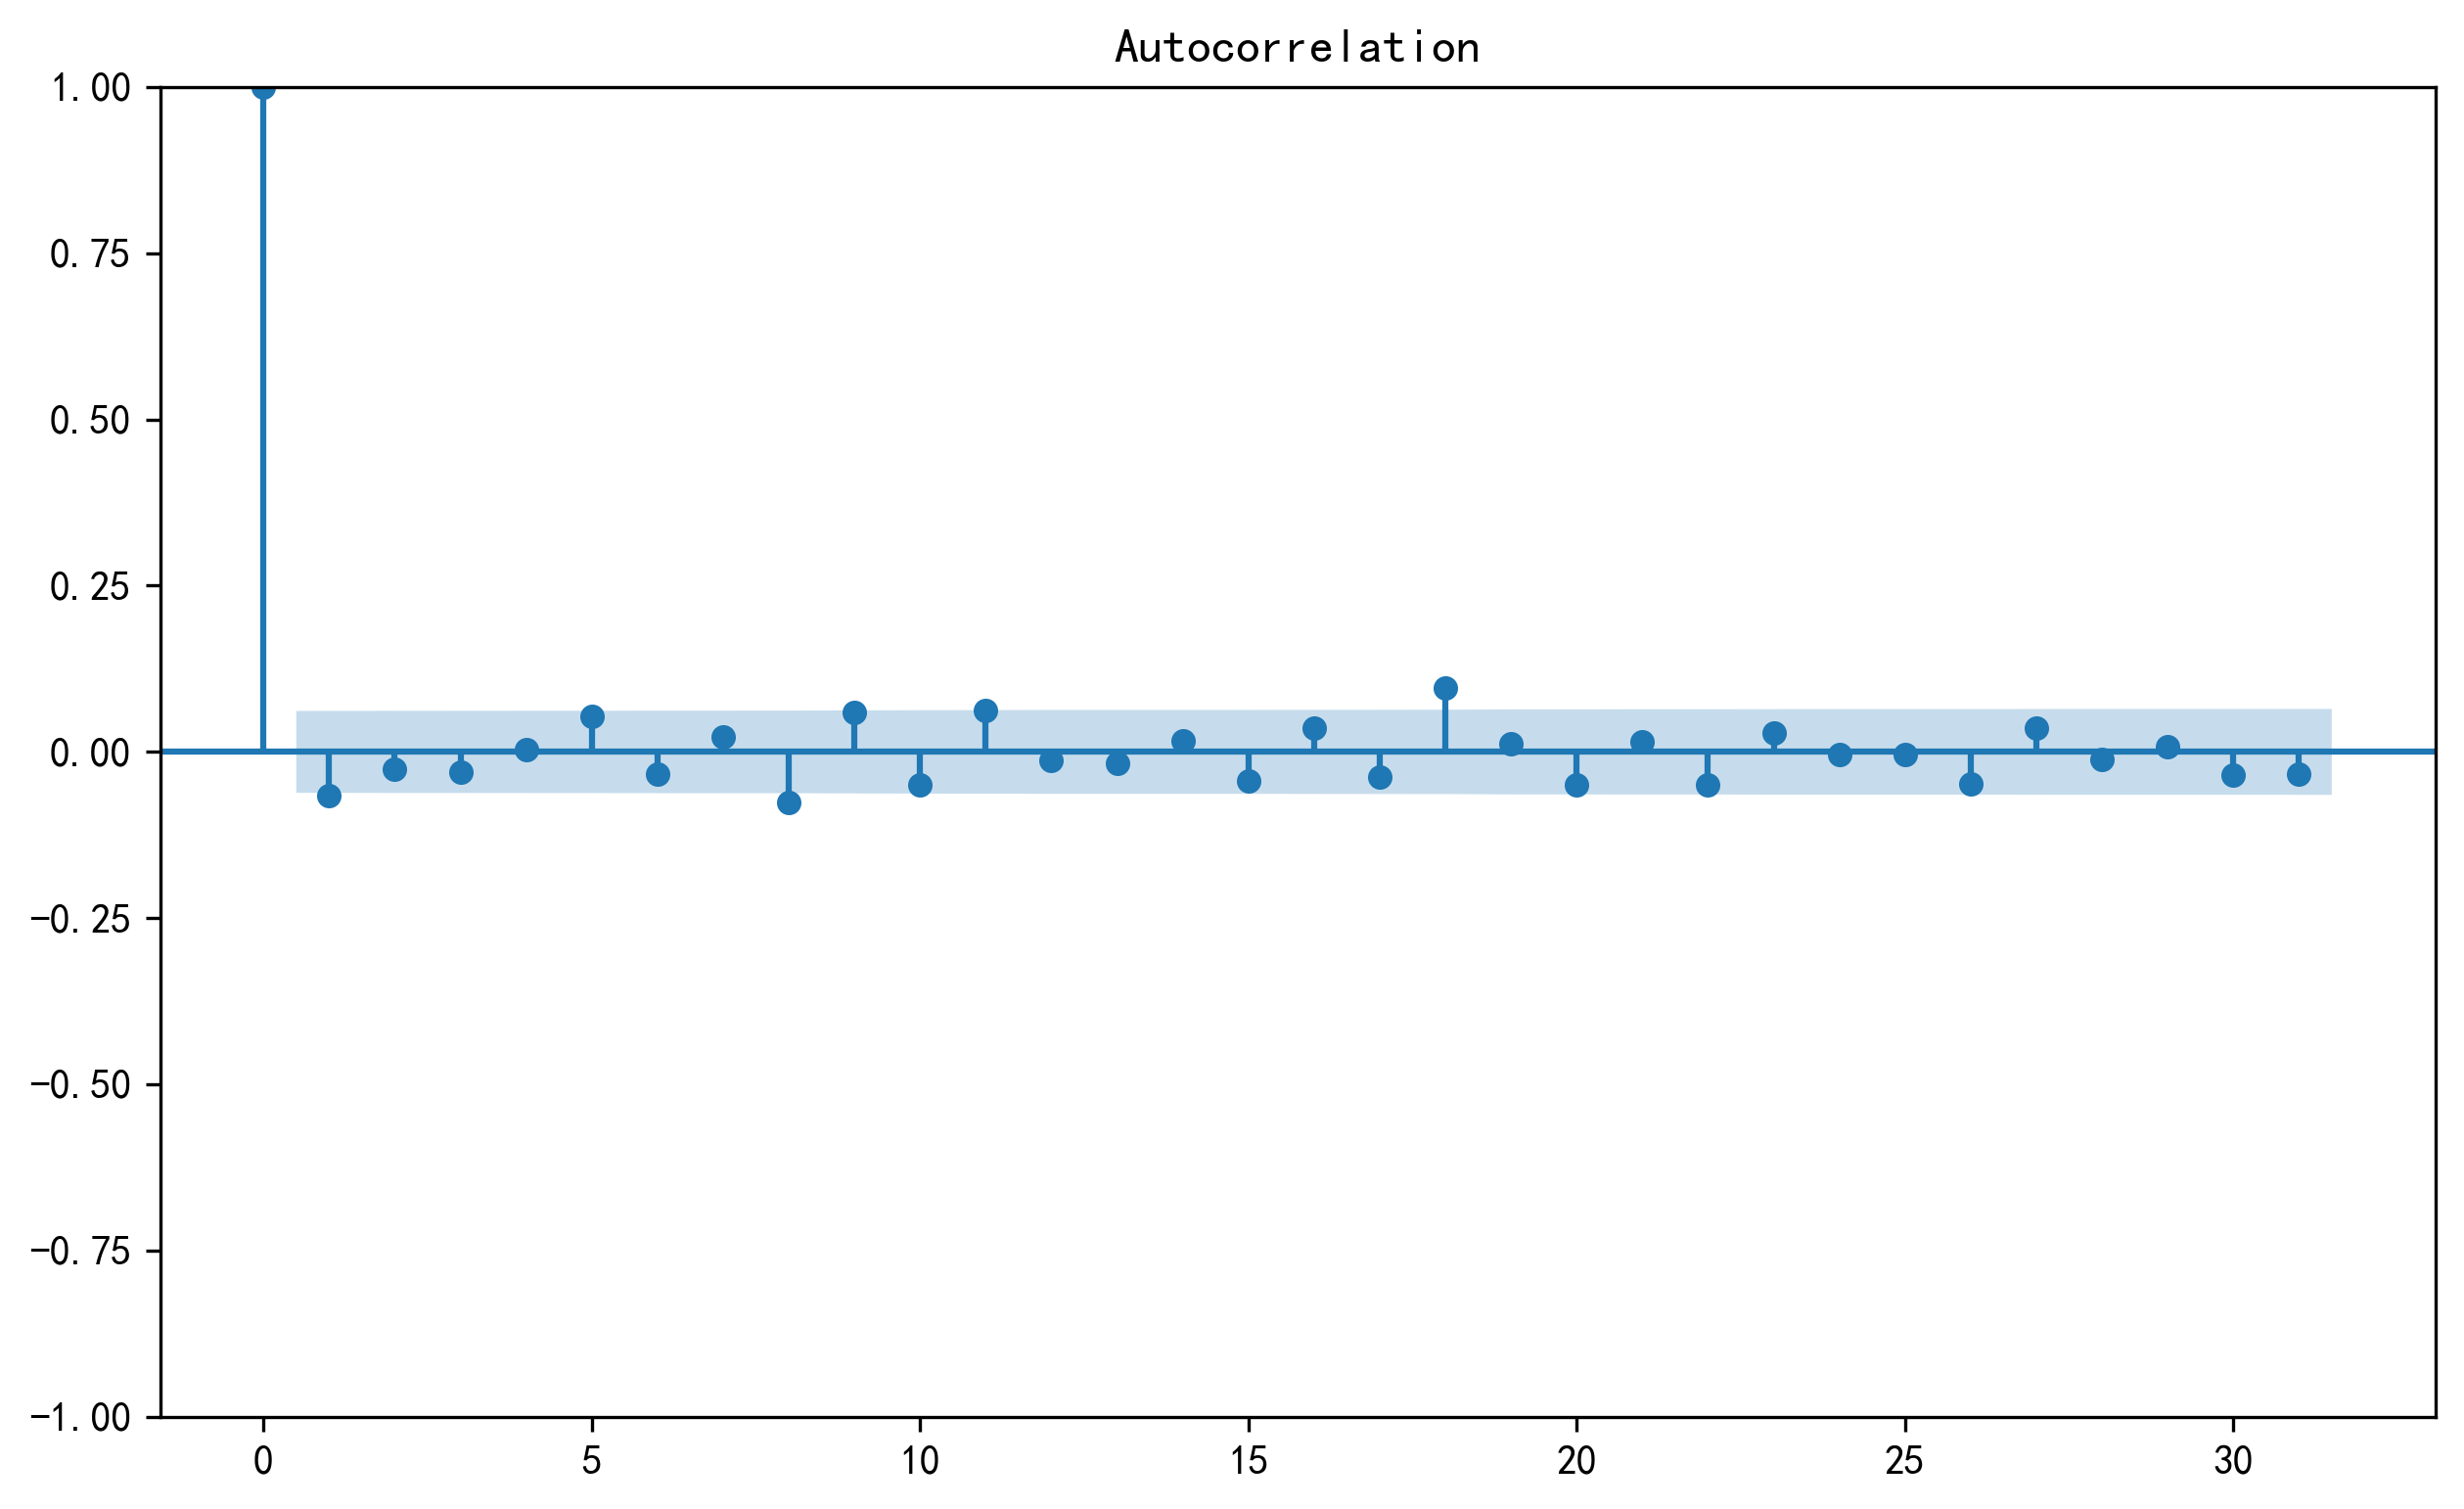

ADF: -9.475724333355902
p-value: 3.9946170934666217e-16


In [36]:
# 设置图像大小和清晰度
fig = plt.figure(figsize=(10, 6), dpi=300)

# 绘制自相关函数图
plot_acf(sta_data, ax=fig.add_subplot(111))

# 显示图像
plt.show()

# 进行ADF检验
adf, p_value, usedlag, nobs, critical_value, icbest = adfuller(sta_data)

# 输出结果
print("ADF:", adf)
print("p-value:", p_value)  # 由p-value知数据平稳性

# 4 ARIMA建模及预测

## (1)建模

In [74]:
# 设置p阶，q阶范围
# product p,q的所有组合
# 设置最好的aic为无穷大
# 对范围内的p,q阶进行模型训练，得到最优模型
ps = range(0, 6)
qs = range(0, 6)
parameters = product(ps, qs)
parameters_list = list(parameters)

start=time.time()
data_size=800
Origin_data=filter_data
predata=Origin_data[:data_size]

best_aic = float('inf')
results = []
for param in parameters_list:
    try:
        model =  sm.tsa.ARIMA(predata, order=(param[0],1 ,param[1])).fit()   #一阶差分
    except ValueError:
        print("参数错误：", param)
        continue
    aic = model.aic            #aic准则来判断
    if aic < best_aic:
        best_model = model     #最好的模型
        best_aic = model.aic
        best_param = param     #最好的参数
    results.append([param, model.aic])
results_table = pd.DataFrame(results)
results_table.columns = ['parameters', 'aic']
print("最优模型", best_model.summary())
print("Duration:",time.time()-start)

最优模型                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 -61.538
Date:                Thu, 27 Jun 2024   AIC                            141.076
Time:                        16:03:18   BIC                            183.226
Sample:                             0   HQIC                           157.269
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3753      0.054      6.921      0.000       0.269       0.482
ar.L2          1.5511      0.040     38.756      0.000       1.473       1.630
ar.L3         -0.4456      0.054     -8.235    

## （2）模型检验

得到白噪声序列，就说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的，残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。如果残差不是白噪声，就说明残差中还有有用的信息，需要修改模型或者进一步提取。

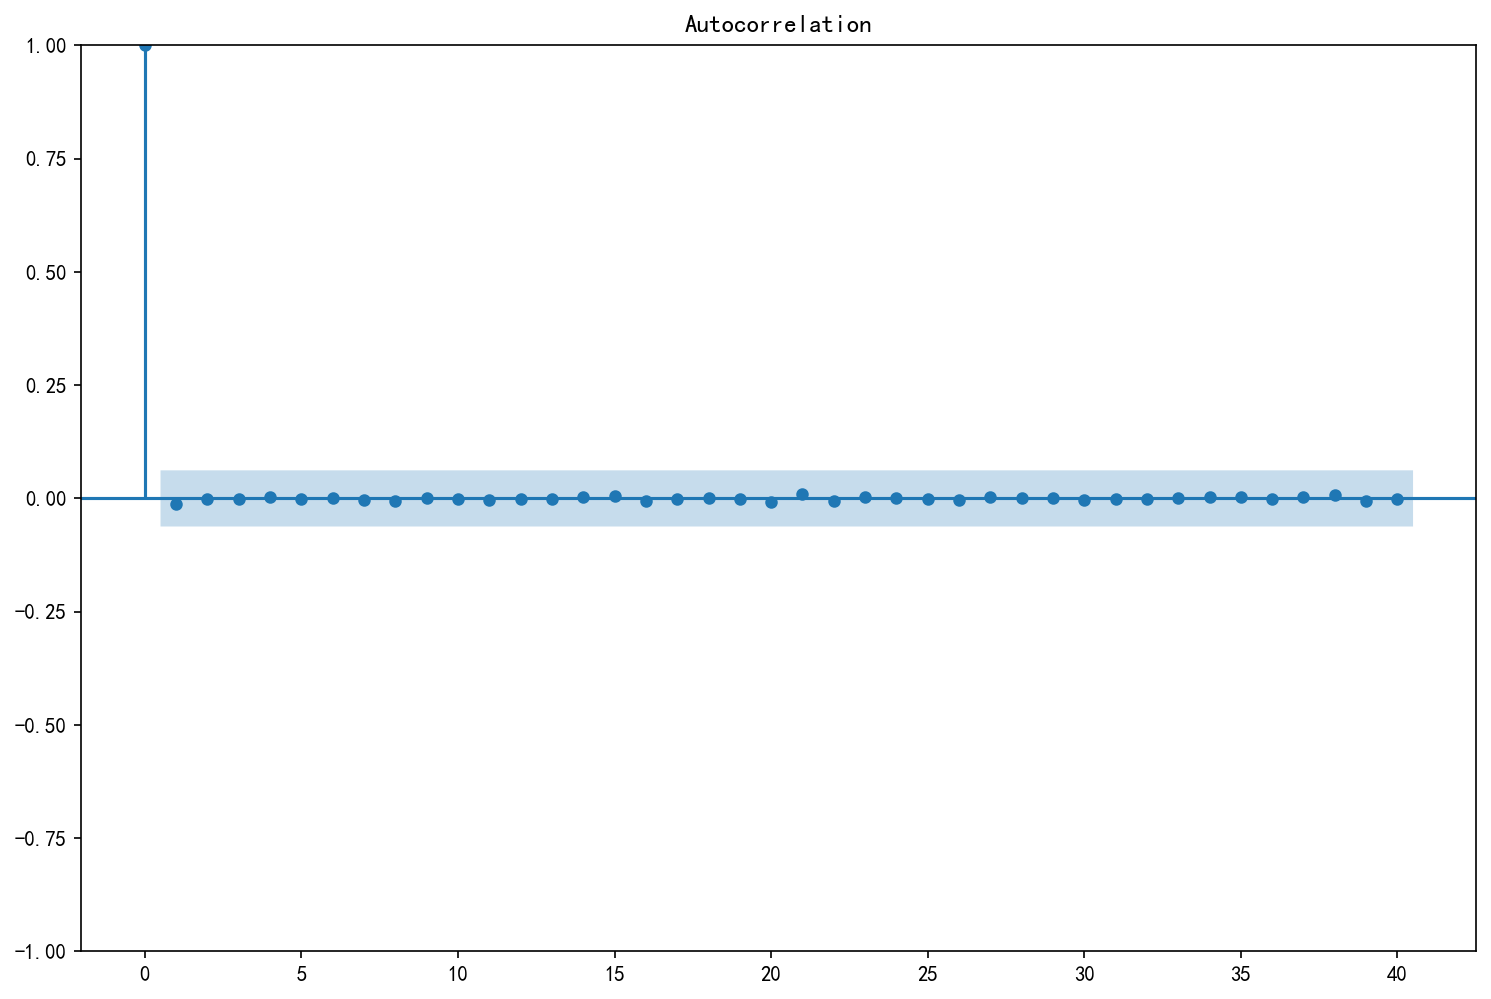

In [48]:
#检验残差的相关性
resid = best_model.resid 
fig = plt.figure(figsize=(12,8),dpi=150)
sm.graphics.tsa.plot_acf(resid, lags=40,ax = fig.add_subplot(111))    #自相关图说明残差不相关，是白噪声
plt.show()     

## （3）模型预测

平均误差为：0.24
相对误差率：0.32%


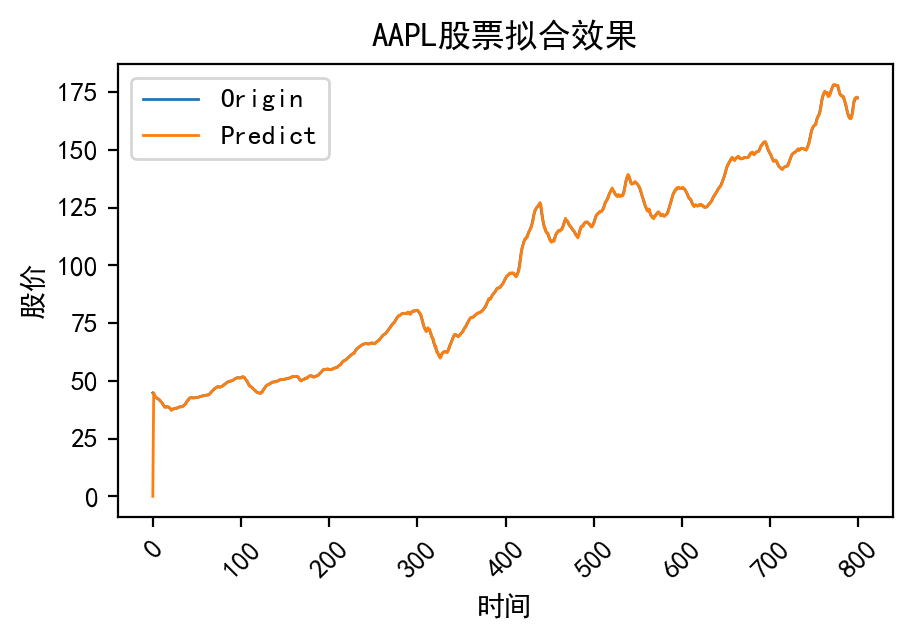

In [75]:
end=800
pred=best_model.predict(start=0,end=end-1).reshape(-1,1)


error=np.sum(np.abs(np.array(pred)-np.array(predata[0:end])))/len(pred)
error_rate=np.sum(np.abs(np.array(pred)-np.array(predata[0:end]))/np.abs(predata[0:end]))/len(pred)
print("平均误差为：{:.2f}".format(error))
print("相对误差率：{:.2f}%".format(error_rate*100))

plt.figure(figsize=(5,3),dpi=200)
plt.plot(stock_data.index[:end],list(predata[0:end]),label="Origin",linewidth=1)
plt.plot(stock_data.index[:end],list(pred),label="Predict",linewidth=1)
plt.xticks(rotation=45)
plt.xlabel("时间")
plt.ylabel("股价")
plt.title("AAPL股票拟合效果")
plt.legend()
plt.show()

误差: 19.963114945087977
相对误差率:11.81%


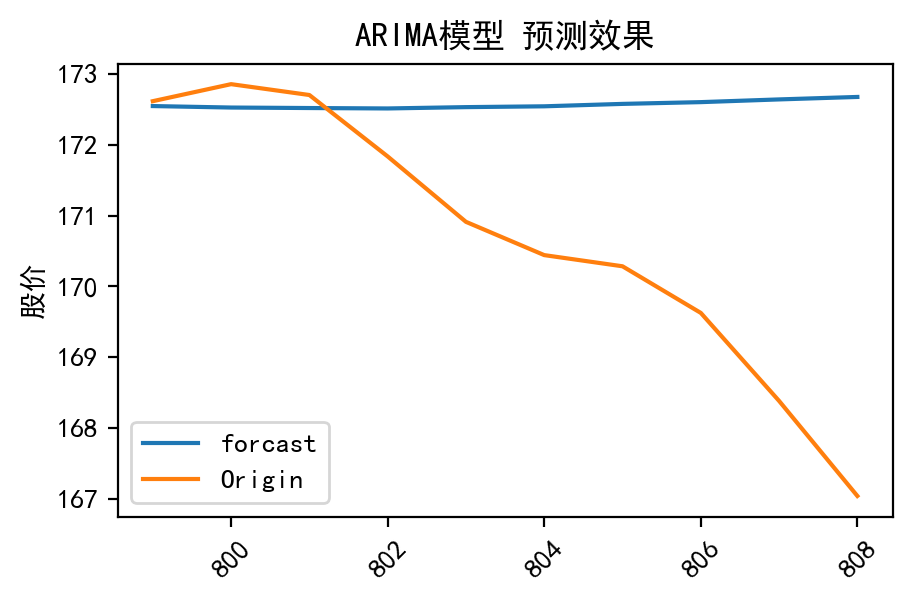

In [85]:
num=10
fore=best_model.forecast(num)    #用forecast函数进行预测
error=np.sum(np.abs(fore-filter_data[data_size:data_size+num]))/num
error_rate=np.sum(np.abs(fore-filter_data[data_size:data_size+num])/np.abs(filter_data[data_size:data_size+num]))/num
print("误差:",error)
print("相对误差率:{:.2f}%".format(error_rate*100))
plt.figure(figsize=(5,3),dpi=200)
plt.plot(list(stock_data.index)[data_size-1:data_size+num-1],list(fore),label="forcast")
plt.plot(list(stock_data.index)[data_size-1:data_size+num-1],list(filter_data[data_size:data_size+num]),label="Origin")
plt.xticks(rotation=45)
plt.legend()
plt.title("ARIMA模型 预测效果")
plt.ylabel("股价")
plt.show()